# 2 практическое задание. Сегментация изображений.

## Практикум на ЭВМ для 317 группы, весна 2021

#### Фамилия, имя: Янаков Дмитрий

Дата выдачи: <span style="color:red">__16 марта 00:00__</span>.

Мягкий дедлайн: <span style="color:red">__30 марта 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __4 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

In [1]:
#предполагается, что датасет лежит в корневой папке гугл диска
from google.colab import drive
drive.mount('/content/drive')
%cd drive
%cd MyDrive

Mounted at /content/drive
/content/drive
/content/drive/MyDrive


В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур `Unet` и `Linknet`. 

Данные для выполнения задания можно скачать по [ссылке](https://disk.yandex.ru/d/tI6d3LBMHTwOnw).

## Загрузка данных (1 балл)

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с imagenet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс `PhotosDataset` для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [2]:
import torch
import torch.nn as nn

import numpy as np
import numpy.testing as npt

from torchvision.models import vgg13
from torch.utils.data import Dataset, DataLoader

# import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
# строка кода выше выдавала ошибку, заменил ее на строку кода ниже
%config InlineBackend.figure_format = 'svg'

import os
from PIL import Image, ImageEnhance
from torchvision.transforms import Compose
from torchvision import transforms

In [10]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        self.images_path = sorted([os.path.abspath(images_dir + '/' + x) for x in os.listdir(images_dir)])
        if target_dir is not None:
            self.target_path = sorted([os.path.abspath(target_dir + '/' + x) for x in os.listdir(target_dir)])
        else:
            self.target_path = None
        if transforms is not None:
            self.transforms = Compose(transforms)
        else:
            self.transforms = Compose([])
        
    def __len__(self):
        return len(self.images_path)
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        image = Image.open(self.images_path[idx])
        if self.target_path is not None:
            mask = Image.open(self.target_path[idx])
            return self.transforms((image, mask))
        else:
            return (self.transform(image), None)

## Модуль аугментации (3 балла)

Конструктор стандартного `ImageFolder`, принимают параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в [документации](https://pytorch.org/vision/0.12/transforms.html).

В данной части вам предлагается самостоятельно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью $p$) горизонтальное отображение (flip) изображения 
* случайное (с вероятностью $p$) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью $p$) изменение яркости изображения (на заданную или случайную величину)
* случайное (с вероятностью $p$) изменение фона изображения (на изображение из заданного списка изображений)

In [3]:
class HorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p
  
    def __call__(self, images):
        if self.p > np.random.rand(1)[0]:
            return tuple(img.transpose(Image.FLIP_LEFT_RIGHT) for img in images)
        else:
            return images

In [4]:
class Cut:
    def __init__(self, p=0.3, size=None):
    # если size = None, то случайный размер
    # иначе тот, который задан
        self.p = p
        self.size = size

    def __call__(self, images):
        if self.p < np.random.rand(1)[0]:
            return images
        else:
            size_old = images[0].size
        if self.size is not None:
            size_new = self.size
        else:
          # чтобы изображение не было слишком маленьким, сделаем нижний порог случайной величины
          # равным трети от исходной величины
            size_new = [np.random.randint(size_old[i] // 3, size_old[i]) for i in range(2)]
        # вырежим наш новый размер из случайного места
        box = list()
        for i in range(2):
            box.append(np.random.randint(0, size_old[i]-size_new[i]+1))
        for i in range(2):
            box.append(box[i] + size_new[i])
        box = tuple(box)
        images_cut = tuple(images[i].crop(box) for i in range(2))
        # вернем изображения к изначальным размерам
        images_cut = tuple(images_cut[i].resize(size_old) for i in range(2))
        return images_cut

In [5]:
class Brightness:
    def __init__(self, p=0.5, additional_br=None):
    # если additional_br = None, то случайная яркость из диапазона [0.5,2.0]
    # иначе измненение от 1 (оригинальное) на ту величину, которая задана
        self.p = p
        if additional_br is not None:
            self.factor = 1 + additional_br
        else:
            self.factor = None

    def __call__(self, images):
        if self.p < np.random.rand(1)[0]:
            return images
        else:
          # нам надо изменить яркость только у изображения
          # маску можно не трогать
            enhancer = ImageEnhance.Brightness(images[0])
            if self.factor is not None:
                img_edited = enhancer.enhance(self.factor)
            else:
                factor = np.random.uniform(0.5,2.0)
                img_edited = enhancer.enhance(factor)
            return (img_edited, images[1])

In [6]:
class Background:
    def __init__(self, p=0.3, background_images=None):
        self.p = p
        self.background_images = background_images

    def __call__(self, images):
        if self.p < np.random.rand(1)[0] and self.background_images is not None:
            return images
        else:
            random_num = np.random.randint(0, len(self.background_images))
            background = Image.open(self.background_images[random_num])
            # создадим картинку с новым фоном на основе маски
            img_edited = Image.composite(images[0], background, images[1])
            return (img_edited, images[1])

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```
transforms.ToTensor()
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
```

In [7]:
# дополнительные трансформации, чтобы подавать парами
class ToTensor:
    def __init__(self):
        self.tensor = transforms.ToTensor()
    def __call__(self, images):
        return tuple(self.tensor(images[i]) for i in range(2))

class Normalize:
    def __init__(self, mean, std):
        self.normalize = transforms.Normalize(mean, std)

    def __call__(self, images):
        return (self.normalize(images[0]), images[1])

In [8]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [11]:
DATA_PATH = 'people_data/'

train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    transforms= [
        HorizontalFlip(),
        Cut(size=(160, 240)),
        Brightness(),
        Background(),
        ToTensor(),
        Normalize(mean=mean, std=std)
    ]
)

test_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'test/',
    target_dir=DATA_PATH + 'test_mask/',
    transforms= [
        ToTensor(),
        Normalize(mean=mean, std=std)
    ]
)

# можем добавить наш датасет в виде фоновых изображений
train_dataset.transforms.transforms[3].background_images = train_dataset.images_path

Функция для отображения изображения:

In [12]:
def show_idx_image(dataset, idx):
    mask_img = dataset[idx]

    image_to_show = mask_img[0].transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    mask_to_show = mask_img[1][0].numpy()

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(7)
    fig.set_figheight(3)


    plt.subplot(1, 2, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show)
    plt.axis('off')

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

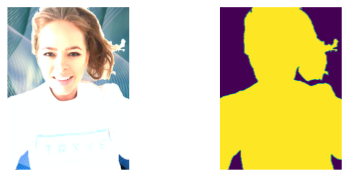

In [ ]:
show_idx_image(train_dataset, 0)
# здесь видна работа повышения яркости и смены фона

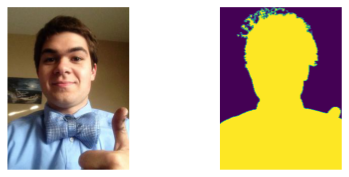

In [ ]:
show_idx_image(train_dataset, 1)
# здесь поворот

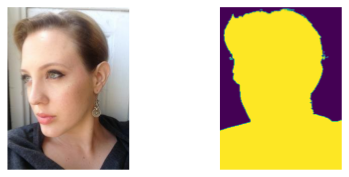

In [ ]:
show_idx_image(train_dataset, 2)
# здесь без изменений

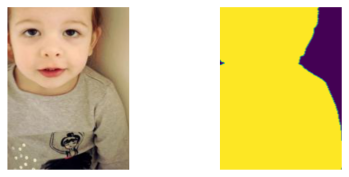

In [ ]:
show_idx_image(train_dataset, 3)
# здесь вырез

## Загрузчики

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры `DataLoader`. При `num_workers`$\;> 1$, батчи готовятся (загружаются картинки, обрабатываются и т.д.) сразу в нескольких фоновых процессах. С помощью параметра `shuffle` можно подавать картинки на обучение в случайном порядке.

In [13]:
train_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=8)

## DiceLoss (1 балл)

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через nn.Module. В ячейке ниже вам предлагается реализовать функцию потерь `dice` (аналог меры Жаккарда).

Результат dice loss определим как:

$$
1 - \frac{2\sum\limits_{i, j}a_{ij}b_{ij}}{\sum\limits_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — разметка для пикселя изображения.

In [14]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        true_labels = true_labels.long()
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        loss = 1 - 2*(logits*true_labels).sum(axis=(1,2)) / ((logits + true_labels).sum(axis=(1,2)) + self.eps)

        if self.reduction == 'sum':
            loss_value = loss.sum()
        elif self.reduction == 'mean':
            loss_value = loss.mean()
        elif self.reduction is None:
            loss_value = loss
            
        return loss_value

Проверка реализации:

In [15]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## Unet (2 балла)

Для решения задачи сегментации будем использовать [UNet](https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного `VGG13`. Архитектура сети реализована за вас ниже.

Энкодер:

In [16]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        # Obtaining pretrained VGG model from torchvision.models and
        # copying all layers except for max pooling.
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[
                    feature_extractor[j]
                    for j in range(i * 5, i * 5 + 4)
                ])
            )

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

Декодер:

In [17]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
        
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(torch.cat([left, x], 1)))
        x = self.relu(self.conv2(x))
        return x

In [18]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

Сеть Unet:

In [19]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Функция для оценивания качества сети:

In [20]:
def evaluate_net(net, testloader, criterion, val_criterion, device='cpu'):
    net = net.eval()

    loss = 0.
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            images = images.to(device)
            
            outputs = net(images).to('cpu')
            total += labels.size(0)
            # loss += float(criterion(outputs, labels).detach())
            # correct += float(val_criterion(outputs, labels).detach())
            loss += criterion(outputs, labels).detach() * labels.size(0)
            correct += val_criterion(outputs, labels).detach() * labels.size(0)
    
    mean_loss = loss / total
    metric = correct / total
    
    return mean_loss, metric

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке. 

Сначала при обучении используйте только кросс-энтропию (`torch.nn.BCEWithLogitsLoss` будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации (только кросс-энтропия, только dice loss, сумма двух лоссов с весами). 

Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.

In [21]:
from tqdm.notebook import tqdm
import torch.optim as optim
from torch.optim import lr_scheduler

В качестве метрики качества будет использовать IoU:

In [22]:
def IoU(outputs, label):
    proba = torch.sigmoid(outputs)
    i = label * proba
    u = torch.sum(label + proba - i)
    return torch.sum(i)/u

In [23]:
# функция для обучения модели
def train(model, name_of_file):
    metric = []
    losss = []
    model = model.to(device)
    for epoch in tqdm(range(num_epoch)):
        model.train()
        for inputs, labels in train_data_loader:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()
        l, m = evaluate_net(model, test_data_loader, criterion, val_criterion, device)
        losss.append(l)
        metric.append(m)
        print(f'epoch = {epoch}')
        print(f'loss = {l}')
        print(f'metric = {m}')
    torch.save(model.state_dict(), name_of_file)
    return losss, metric

In [24]:
# функция для печати картинок, их масок и результата работы нейронной сети
def make_plot(model, dataloader):
    images, target = next(iter(dataloader))
    model.eval()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    with torch.no_grad():
        out = model(images.to(device)).cpu()
    size = len(images)
    sigmoid = torch.sigmoid(out)
    plt.figure(figsize=(8, 9))
    for i in range(size//2):
        for j in range(2):
            plt.subplot(size//2, 6, 1+i*6+j*3)
            img = np.clip(images[i*2+j].permute(1, 2, 0).numpy()*mean+std, a_min = 0, a_max = 1)
            plt.imshow(img)
            plt.axis('off')
            plt.subplot(size//2, 6, 2+i*6+j*3)
            plt.imshow(target[i*2+j].squeeze())
            plt.axis('off')
            plt.subplot(size//2, 6, 3+i*6+j*3)
            plt.imshow(sigmoid[i*2+j].squeeze())
            plt.axis('off')
    plt.tight_layout()

####Кросс-энтропия:

In [ ]:
model = UNet()

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth


  0%|          | 0.00/508M [00:00<?, ?B/s]

In [ ]:
num_epoch = 15
lr = 1e-4
weight_decay = 1e-4
step_size = 50
gamma = 0.5

In [ ]:
val_criterion = IoU
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
print(device)

cuda:0


In [ ]:
loss_list , metric_list = train(model, "path_to_model.pth")

  0%|          | 0/15 [00:00<?, ?it/s]

epoch = 0
loss = 0.2708345949649811
metric = 0.706820547580719
epoch = 1
loss = 0.2271825075149536
metric = 0.7938309907913208
epoch = 2
loss = 0.25073641538619995
metric = 0.7294862866401672
epoch = 3
loss = 0.18019723892211914
metric = 0.8204528093338013
epoch = 4
loss = 0.17665058374404907
metric = 0.8224617838859558
epoch = 5
loss = 0.17947739362716675
metric = 0.8132892847061157
epoch = 6
loss = 0.15944239497184753
metric = 0.8460405468940735
epoch = 7
loss = 0.1552177518606186
metric = 0.8564000725746155
epoch = 8
loss = 0.1419181525707245
metric = 0.8597647547721863
epoch = 9
loss = 0.14931118488311768
metric = 0.8629365563392639
epoch = 10
loss = 0.17469821870326996
metric = 0.8221919536590576
epoch = 11
loss = 0.1423243284225464
metric = 0.8576264381408691
epoch = 12
loss = 0.15020045638084412
metric = 0.8553958535194397
epoch = 13
loss = 0.1432008147239685
metric = 0.8683329224586487
epoch = 14
loss = 0.14531895518302917
metric = 0.8723905682563782


In [ ]:
model.load_state_dict(torch.load('path_to_model.pth'))

<All keys matched successfully>

Ниже и далее будут изображены картинки в следующем порядке:
непосредственно само изображение, маска и результат работы нейронной сети.

Здесь изображен результат работы UNet с кросс-энтропией. Следующие два графика также относятся к этой модели.

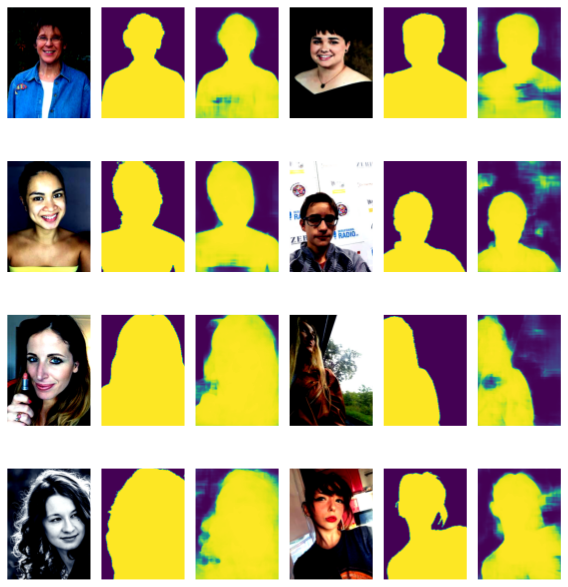

In [ ]:
make_plot(model, test_data_loader)

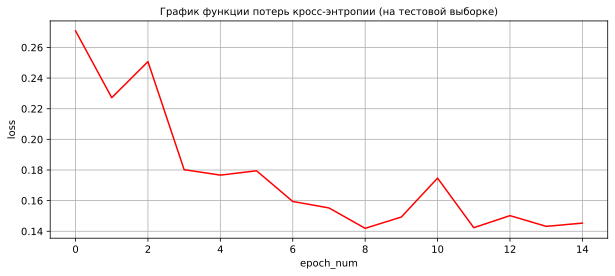

In [ ]:
plt.figure(figsize=(10,4))
plt.title('График функции потерь кросс-энтропии (на тестовой выборке)',fontsize=10)
plt.plot([x for x in range(15)], loss_list, linestyle='-', color='r')
plt.grid(True) 
plt.ylabel('loss',  fontsize=10)
plt.xlabel('epoch_num',  fontsize=10)
plt.show()

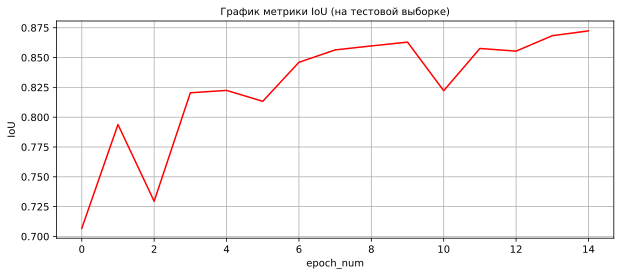

In [ ]:
plt.figure(figsize=(10,4))
plt.title('График метрики IoU (на тестовой выборке)',fontsize=10)
plt.plot([x for x in range(15)], metric_list, linestyle='-', color='r')
plt.grid(True) 
plt.ylabel('IoU',  fontsize=10)
plt.xlabel('epoch_num',  fontsize=10)
plt.show()

*Вывод для UNet с кросс-энтропией:*

1) Среднее время прохода по эпохе - около 5 минут (если быть точнее - 307 секунд), качество - около 0.875, лосс - почти приблизился к 0.14.

2) Что касается изображений - некоторые сегментировались достаточно неплохо, однако видны дефекты в виде отверстий, а также внешнего шума.

P.S. : результаты здесь и далее по времени получены при использовании GPU в Google Colab

####DiceLoss

In [ ]:
model = UNet()

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth


  0%|          | 0.00/508M [00:00<?, ?B/s]

In [ ]:
num_epoch = 15
lr = 1e-4
weight_decay = 1e-4
step_size = 50
gamma = 0.5

In [ ]:
val_criterion = IoU
criterion = DiceLoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
print(device)

cuda:0


In [ ]:
loss_list , metric_list = train(model, "path_to_model2.pth")

  0%|          | 0/15 [00:00<?, ?it/s]

epoch = 0
loss = 0.3031523823738098
metric = 0.6039797067642212
epoch = 1
loss = 0.3031523823738098
metric = 0.6039797067642212
epoch = 2
loss = 0.3031523823738098
metric = 0.6039797067642212
epoch = 3
loss = 0.3031523525714874
metric = 0.6039808392524719
epoch = 4
loss = 0.30315229296684265
metric = 0.6039800643920898
epoch = 5
loss = 0.3031511902809143
metric = 0.60398268699646
epoch = 6
loss = 0.29376220703125
metric = 0.6210789084434509
epoch = 7
loss = 0.22961214184761047
metric = 0.724021315574646
epoch = 8
loss = 0.2180423140525818
metric = 0.7458726167678833
epoch = 9
loss = 0.20449396967887878
metric = 0.768869936466217
epoch = 10
loss = 0.19196663796901703
metric = 0.7946040630340576
epoch = 11
loss = 0.19941352307796478
metric = 0.7925685048103333
epoch = 12
loss = 0.181745707988739
metric = 0.8107863664627075
epoch = 13
loss = 0.18028753995895386
metric = 0.8089482188224792
epoch = 14
loss = 0.17250840365886688
metric = 0.8230989575386047


In [ ]:
model.load_state_dict(torch.load('path_to_model2.pth'))

<All keys matched successfully>

Здесь изображен результат работы UNet с DiceLoss. Следующие два графика также относятся к этой модели.

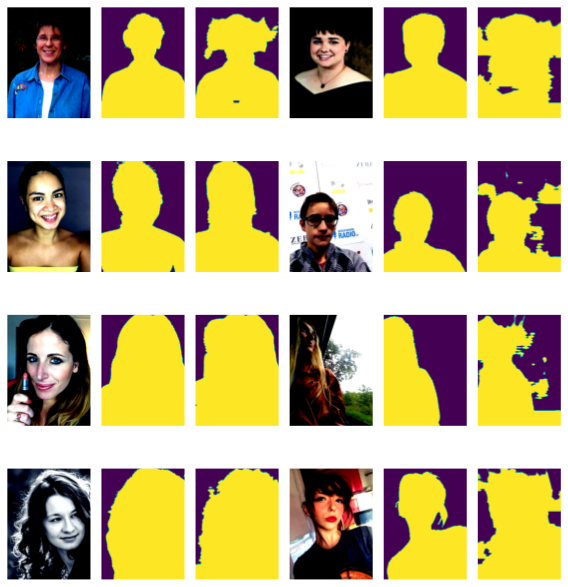

In [ ]:
make_plot(model, test_data_loader)

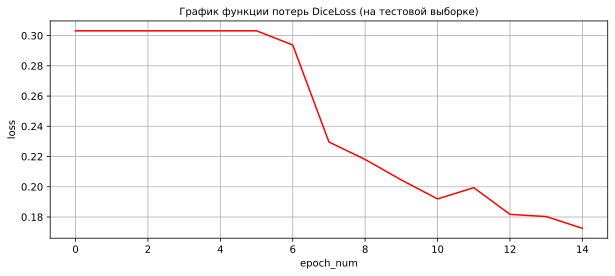

In [ ]:
plt.figure(figsize=(10,4))
plt.title('График функции потерь DiceLoss (на тестовой выборке)',fontsize=10)
plt.plot([x for x in range(15)], loss_list, linestyle='-', color='r')
plt.grid(True) 
plt.ylabel('loss',  fontsize=10)
plt.xlabel('epoch_num',  fontsize=10)
plt.show()

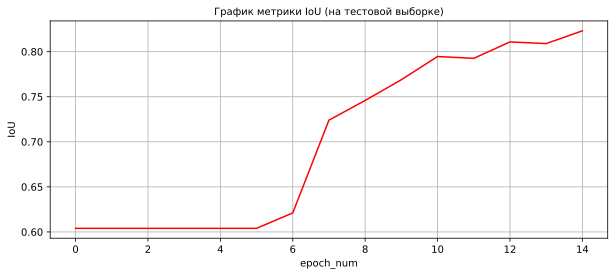

In [ ]:
plt.figure(figsize=(10,4))
plt.title('График метрики IoU (на тестовой выборке)',fontsize=10)
plt.plot([x for x in range(15)], metric_list, linestyle='-', color='r')
plt.grid(True) 
plt.ylabel('IoU',  fontsize=10)
plt.xlabel('epoch_num',  fontsize=10)
plt.show()

*Вывод для UNet с DiceLoss:*

1) Среднее время прохода по эпохе - около 5 минут (если быть точнее - 298 секунд), качество - около 0.823 (меньше, чем при использовании кросс-энтропии), лосс - почти приблизился к 0.17. Возможно, модели не хватило 15 эпох, чтобы добиться большего качества и меньшего лосса.  Можно также заметить, что здесь модель 5 эпох практически не сдвигается с ровного места. Лишь после происходит улучшение. И на графиках нет таких скачков, как при использовании кросс-энтропии.

2) Что касается изображений - внешний шум, который при кросс-энтропии был менее уверенный, тут считается как за объект (что есть плохо), однако некоторые отверстися были включены в маску (что есть хорошо).

####Кросс-энтропия + DiceLoss (у каждой вес 1/2)

In [32]:
class DiceLoss_CrossEntropy(nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        super().__init__()
        self.DiceLoss = DiceLoss(reduction='mean')
        self.LogitsLoss = nn.BCEWithLogitsLoss()
        
    def forward(self, logits, true_labels):
        return 1/2*(self.DiceLoss.forward(logits,true_labels) + self.LogitsLoss.forward(logits,true_labels))

In [ ]:
model = UNet()

In [ ]:
num_epoch = 15
lr = 1e-4
weight_decay = 1e-4
step_size = 50
gamma = 0.5

In [ ]:
val_criterion = IoU
criterion = DiceLoss_CrossEntropy()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
print(device)

cuda:0


In [ ]:
loss_list , metric_list = train(model, "path_to_model3.pth")

  0%|          | 0/15 [00:00<?, ?it/s]

epoch = 0
loss = 0.21989218890666962
metric = 0.8040450215339661
epoch = 1
loss = 0.20114701986312866
metric = 0.8019723296165466
epoch = 2
loss = 0.17221572995185852
metric = 0.8435661196708679
epoch = 3
loss = 0.17112287878990173
metric = 0.8478851318359375
epoch = 4
loss = 0.16121871769428253
metric = 0.8571510910987854
epoch = 5
loss = 0.16591472923755646
metric = 0.8470925092697144
epoch = 6
loss = 0.15683671832084656
metric = 0.8730435371398926
epoch = 7
loss = 0.15527930855751038
metric = 0.8522144556045532
epoch = 8
loss = 0.14661921560764313
metric = 0.8851850628852844
epoch = 9
loss = 0.15451054275035858
metric = 0.8557060360908508
epoch = 10
loss = 0.1441253274679184
metric = 0.878938615322113
epoch = 11
loss = 0.1580335646867752
metric = 0.870864748954773
epoch = 12
loss = 0.14416013658046722
metric = 0.890259861946106
epoch = 13
loss = 0.13748031854629517
metric = 0.8996996879577637
epoch = 14
loss = 0.1353931725025177
metric = 0.8960467576980591


In [ ]:
model.load_state_dict(torch.load('path_to_model3.pth'))

<All keys matched successfully>

Здесь изображен результат работы UNet с кросс-энтропией + DiceLoss (у каждой функции вес равен 1/2). Следующие два графика также относятся к этой модели.

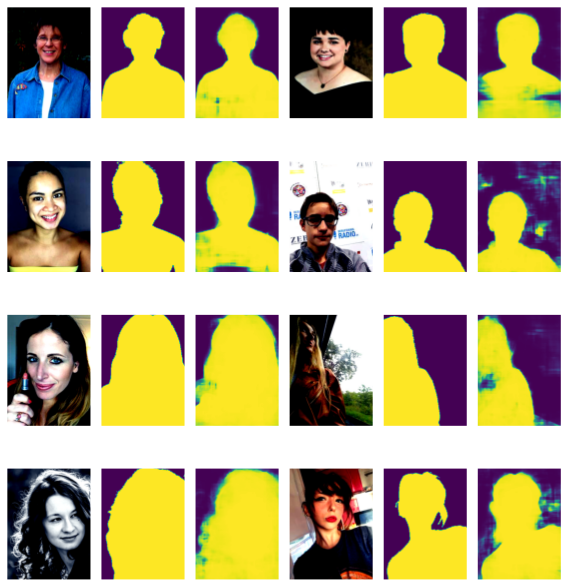

In [ ]:
make_plot(model, test_data_loader)

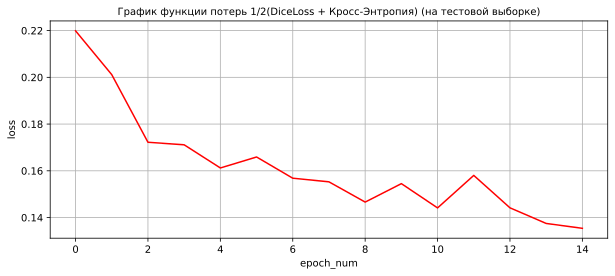

In [ ]:
plt.figure(figsize=(10,4))
plt.title('График функции потерь 1/2(DiceLoss + Кросс-Энтропия) (на тестовой выборке)',fontsize=10)
plt.plot([x for x in range(15)], loss_list, linestyle='-', color='r')
plt.grid(True) 
plt.ylabel('loss',  fontsize=10)
plt.xlabel('epoch_num',  fontsize=10)
plt.show()

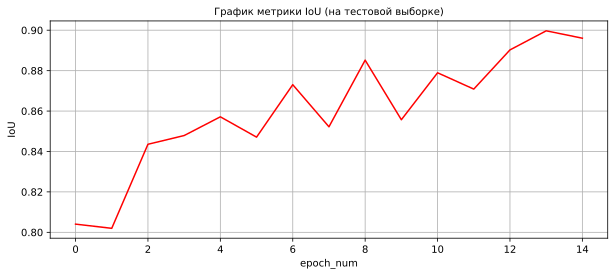

In [ ]:
plt.figure(figsize=(10,4))
plt.title('График метрики IoU (на тестовой выборке)',fontsize=10)
plt.plot([x for x in range(15)], metric_list, linestyle='-', color='r')
plt.grid(True) 
plt.ylabel('IoU',  fontsize=10)
plt.xlabel('epoch_num',  fontsize=10)
plt.show()

*Вывод для UNet с кросс-энтропией + DiceLoss (у каждой функции вес равен 1/2):*

1) Среднее время прохода по эпохе - около 4.5 минут (если быть точнее - 276 секунд), качество - доходило практически до 0.9 (больше, чем в предыдущих двух подходах), лосс - около 0.135.

2) Что касается изображений - видна тендеция, что результат похож на что-то среднее между двумя предыдущими подходами: лучше закрываются отверстия (то есть модель более уверенна на них), а внешний шум не такой плохой, как при использовании DiceLoss.

## LinkNet (2 балла)

Реализуйте архитектуру [LinkNet](https://arxiv.org/pdf/1707.03718.pdf) с использованием энкодера, основанного на `VGG13`. Архитектура похожа на `Unet`, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

Обучите сеть и проведите анализ согласно предыдущему пункту.

In [25]:
class DecoderBlockLinkNet(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
        
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(x+left))
        x = self.relu(self.conv2(x))
        return x

In [26]:
class DecoderLinkNet(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlockLinkNet(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

In [27]:
class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = DecoderLinkNet(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Обучите LinkNet. Сравните LinkNet и Unet по качеству и скорости работы. Сделайте выводы. 

####Кросс-энтропия:

In [ ]:
model = LinkNet()

In [ ]:
num_epoch = 15
lr = 1e-4
weight_decay = 1e-4
step_size = 50
gamma = 0.5

In [ ]:
val_criterion = IoU
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
print(device)

cuda:0


In [ ]:
loss_list , metric_list = train(model, "path_to_model4.pth")

  0%|          | 0/15 [00:00<?, ?it/s]

epoch = 0
loss = 0.2666792571544647
metric = 0.7276344299316406
epoch = 1
loss = 0.2054370641708374
metric = 0.8116185069084167
epoch = 2
loss = 0.17042191326618195
metric = 0.8291582465171814
epoch = 3
loss = 0.16989721357822418
metric = 0.826680064201355
epoch = 4
loss = 0.15822112560272217
metric = 0.8605316281318665
epoch = 5
loss = 0.1813584715127945
metric = 0.80978924036026
epoch = 6
loss = 0.14598898589611053
metric = 0.863017737865448
epoch = 7
loss = 0.18063762784004211
metric = 0.8387749195098877
epoch = 8
loss = 0.16690468788146973
metric = 0.8558166027069092
epoch = 9
loss = 0.1403043419122696
metric = 0.8755488991737366
epoch = 10
loss = 0.14329953491687775
metric = 0.8676191568374634
epoch = 11
loss = 0.16405043005943298
metric = 0.8299360275268555
epoch = 12
loss = 0.13446055352687836
metric = 0.8848784565925598
epoch = 13
loss = 0.14299599826335907
metric = 0.8572351932525635
epoch = 14
loss = 0.13620980083942413
metric = 0.8909480571746826


In [ ]:
model.load_state_dict(torch.load('path_to_model4.pth'))

<All keys matched successfully>

Здесь изображен результат работы LinkNet с кросс-энтропией. Следующие два графика также относятся к этой модели.

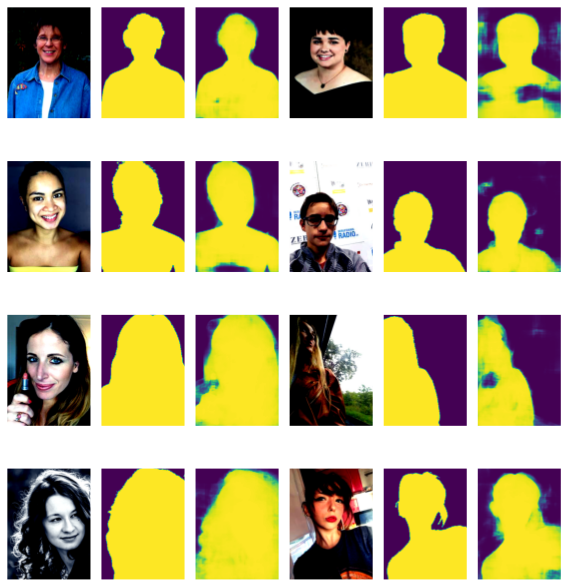

In [ ]:
make_plot(model, test_data_loader)

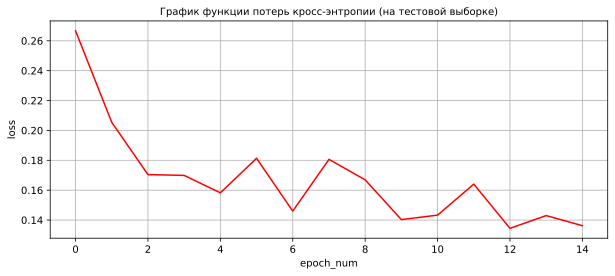

In [ ]:
plt.figure(figsize=(10,4))
plt.title('График функции потерь кросс-энтропии (на тестовой выборке)',fontsize=10)
plt.plot([x for x in range(15)], loss_list, linestyle='-', color='r')
plt.grid(True) 
plt.ylabel('loss',  fontsize=10)
plt.xlabel('epoch_num',  fontsize=10)
plt.show()

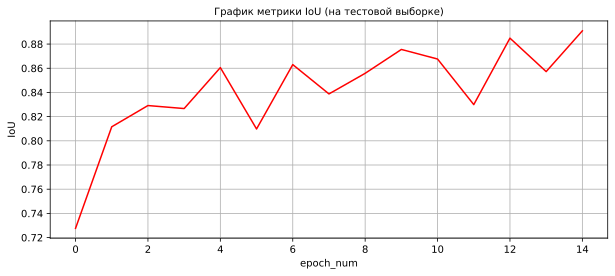

In [ ]:
plt.figure(figsize=(10,4))
plt.title('График метрики IoU (на тестовой выборке)',fontsize=10)
plt.plot([x for x in range(15)], metric_list, linestyle='-', color='r')
plt.grid(True) 
plt.ylabel('IoU',  fontsize=10)
plt.xlabel('epoch_num',  fontsize=10)
plt.show()

*Вывод для LinkNet с кросс-энтропией:*

1) Среднее время прохода по эпохе - около 4 минут 20 секунд (если быть точнее - 256 секунд), качество - около 0.89, лосс - 0.136.

2) Что касается изображений - кажется, что сегментация по сравнению с UNet (с кросс-энтропией) лучше: больше уверенности в отверстиях и меньше уверенности в шуме. Если сравнивать с UNet со взвешенной функцией, то там будет больше уверенности в отверстиях, однако хуже ситуация со внешним шумом (его там побольше).

####DiceLoss:

In [ ]:
model = LinkNet()

In [ ]:
num_epoch = 15
lr = 1e-4
weight_decay = 1e-4
step_size = 50
gamma = 0.5

In [ ]:
val_criterion = IoU
criterion = DiceLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
print(device)

cuda:0


In [ ]:
loss_list , metric_list = train(model, "path_to_model5.pth")

  0%|          | 0/15 [00:00<?, ?it/s]

epoch = 0
loss = 0.3031523823738098
metric = 0.6039797067642212
epoch = 1
loss = 0.3031523823738098
metric = 0.6039797067642212
epoch = 2
loss = 0.3031523823738098
metric = 0.603979766368866
epoch = 3
loss = 0.30315274000167847
metric = 0.6039815545082092
epoch = 4
loss = 0.30238696932792664
metric = 0.6051546335220337
epoch = 5
loss = 0.3031523823738098
metric = 0.603979766368866
epoch = 6
loss = 0.3004132807254791
metric = 0.6078724265098572
epoch = 7
loss = 0.3031523823738098
metric = 0.6039797067642212
epoch = 8
loss = 0.3031519949436188
metric = 0.6039807200431824
epoch = 9
loss = 0.2894929051399231
metric = 0.6271528601646423
epoch = 10
loss = 0.2550314664840698
metric = 0.6906052827835083
epoch = 11
loss = 0.24367234110832214
metric = 0.7141829133033752
epoch = 12
loss = 0.22615596652030945
metric = 0.7317695021629333
epoch = 13
loss = 0.21211305260658264
metric = 0.7572115063667297
epoch = 14
loss = 0.20055708289146423
metric = 0.7802473306655884


In [ ]:
model.load_state_dict(torch.load('path_to_model5.pth'))

<All keys matched successfully>

Здесь изображен результат работы LinkNet с DiceLoss. Следующие два графика также относятся к этой модели.

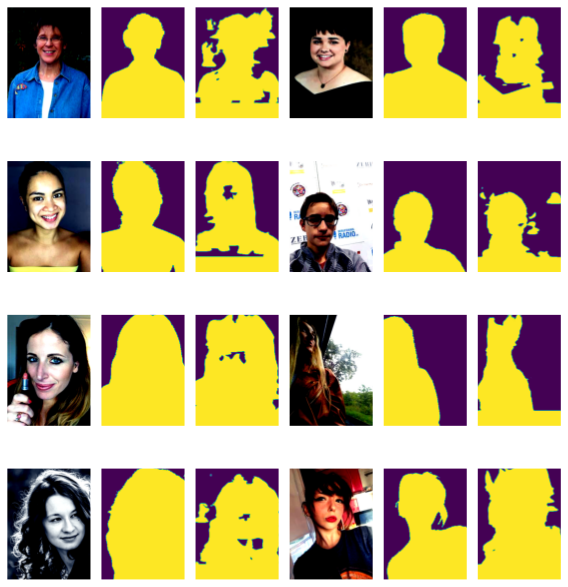

In [ ]:
make_plot(model, test_data_loader)

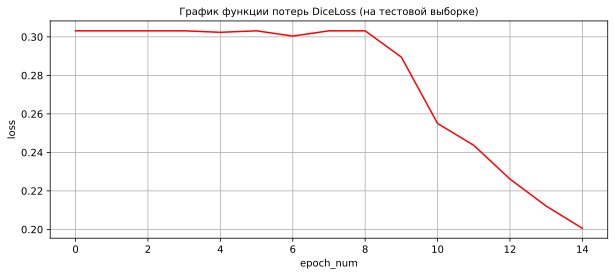

In [ ]:
plt.figure(figsize=(10,4))
plt.title('График функции потерь DiceLoss (на тестовой выборке)',fontsize=10)
plt.plot([x for x in range(15)], loss_list, linestyle='-', color='r')
plt.grid(True) 
plt.ylabel('loss',  fontsize=10)
plt.xlabel('epoch_num',  fontsize=10)
plt.show()

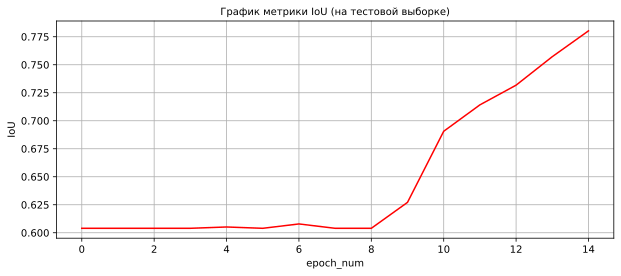

In [ ]:
plt.figure(figsize=(10,4))
plt.title('График метрики IoU (на тестовой выборке)',fontsize=10)
plt.plot([x for x in range(15)], metric_list, linestyle='-', color='r')
plt.grid(True) 
plt.ylabel('IoU',  fontsize=10)
plt.xlabel('epoch_num',  fontsize=10)
plt.show()

*Вывод для LinkNet с DiceLoss:*

1) Среднее время прохода по эпохе - около 4 минут (если быть точнее - 249 секунд), качество - около 0.79 (самое маленькое качество из всех проводимых экспериментов), лосс - 0.2 (самый большой лосс в проводимых экспериментах). Тут может быть аналогичный сценарий, как в UNet - модели могло не хватить 15 эпох, чтобы получше обучиться, а также что уже 8 (а не 5, как в случае с UNet) эпох модель практически не сдвигается с ровного места.

2) Что касается изображений - сегментация конечно же хуже, чем в UNet.

####Кросс-энтропия + DiceLoss (у каждой вес 1/2):

In [ ]:
model = LinkNet()

In [ ]:
num_epoch = 15
lr = 1e-4
weight_decay = 1e-4
step_size = 50
gamma = 0.5

In [ ]:
val_criterion = IoU
criterion = DiceLoss_CrossEntropy()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
print(device)

cuda:0


In [ ]:
loss_list , metric_list = train(model, "path_to_model6.pth")

  0%|          | 0/15 [00:00<?, ?it/s]

epoch = 0
loss = 0.2241085022687912
metric = 0.7982177138328552
epoch = 1
loss = 0.19191601872444153
metric = 0.824621856212616
epoch = 2
loss = 0.18998262286186218
metric = 0.8258061408996582
epoch = 3
loss = 0.20872649550437927
metric = 0.8242182731628418
epoch = 4
loss = 0.1715799868106842
metric = 0.8321009278297424
epoch = 5
loss = 0.14828835427761078
metric = 0.8854399919509888
epoch = 6
loss = 0.14775830507278442
metric = 0.8739941120147705
epoch = 7
loss = 0.15311580896377563
metric = 0.8787258267402649
epoch = 8
loss = 0.15165665745735168
metric = 0.8712974190711975
epoch = 9
loss = 0.15642708539962769
metric = 0.8696951270103455
epoch = 10
loss = 0.15998536348342896
metric = 0.8523693680763245
epoch = 11
loss = 0.1378016471862793
metric = 0.887917697429657
epoch = 12
loss = 0.14350849390029907
metric = 0.8850430250167847
epoch = 13
loss = 0.14814603328704834
metric = 0.8760191202163696
epoch = 14
loss = 0.13711310923099518
metric = 0.8934059143066406


In [ ]:
model.load_state_dict(torch.load('path_to_model6.pth'))

<All keys matched successfully>

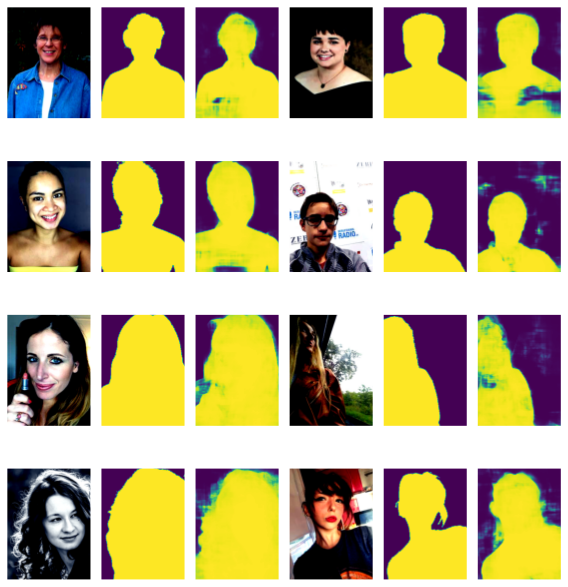

In [ ]:
make_plot(model, test_data_loader)

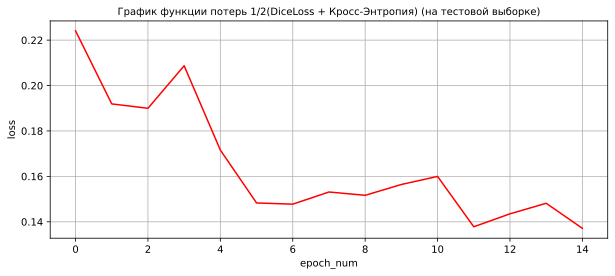

In [ ]:
plt.figure(figsize=(10,4))
plt.title('График функции потерь 1/2(DiceLoss + Кросс-Энтропия) (на тестовой выборке)',fontsize=10)
plt.plot([x for x in range(15)], loss_list, linestyle='-', color='r')
plt.grid(True) 
plt.ylabel('loss',  fontsize=10)
plt.xlabel('epoch_num',  fontsize=10)
plt.show()

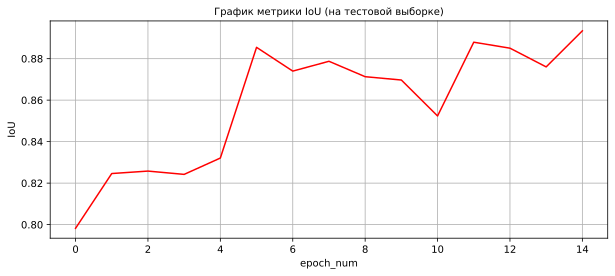

In [ ]:
plt.figure(figsize=(10,4))
plt.title('График метрики IoU (на тестовой выборке)',fontsize=10)
plt.plot([x for x in range(15)], metric_list, linestyle='-', color='r')
plt.grid(True) 
plt.ylabel('IoU',  fontsize=10)
plt.xlabel('epoch_num',  fontsize=10)
plt.show()

*Вывод для LinkNet с кросс-энтропией + DiceLoss (у каждой функции вес равен 1/2):*

1) Среднее время прохода по эпохе - около 4 минут 20 секунд (если быть точнее - 254 секунды), качество - чуть выше 0.89 (можно заметить, что достаточно быстро перешло порог в 0.88), лосс - около 0.137.

2) Что касается изображений - модель чуть лучше справилась по сравнению с UNet (со взвешенной функцией потерь) в плане внешнего шума, но в отверстиях менее уверенна.

**Общий вывод:**

1) Большего качества добилась UNet (со взвешенной функией), однако LinkNet (с такой же функцией) показал почти такой же результат

2) По времени все модели работают примерно одинаково (за исключением может быть UNet с кросс-энтропией)

3) Качество сильно просело при использовании LinkNet с DiceLoss

4) При использовании DiceLoss (как в случае UNet, так в случе LinkNet) на графиках функции потерь и качества нет сильных скачков

## Теоретические вопросы (1 балл)

### Вопрос 1.
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура свёрточных сетей. 
* Какие преимущества дает использование сверток в случае, если эти предположения верные? 
* Приведите пример входных данных, когда эти предположения не выполняются.

1) Узоры и паттерны в изображении повторяются, создавая некую однообразную текстуру. Преимущество - возможность обучаться быстрее.

2) Узоры и паттерны, которые отвечают за объект, который мы хотим классифицировать/сегментировать, в изображении располагаются близко друг к другу. Преимущество - свёртка эффективнее собирает информацию.

Пример данных, когда эти предположения не выполняются:
например, на изображении располагается предмет, который разделен на части и по отдельности не представляет собой цельной структуры (или же на изображении есть сильные шумы). К примеру, в слове есть пропуски или лицо человека сильно зашумлено, что не позволяет выделить в нем признаки человека.


### Вопрос 2
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$. 

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации. 

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите: 

1. Размерность выходного пространства. 
2. Количество обучаемых параметров. 
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

Для ${f(\cdot)}$: \\
1) Размерность выходного пространства: 1.000 x 1 \\
2) Количество обучаемых параметров: 100.000 \\
3) Число операций при выполнении forward pass: 99.000 сложений, 100.000 умножений и 1.000 операций применения 𝜎(⋅) 

Для ${g(\cdot)}$: \\
1) Размерность выходного пространства: 100 x 10 \\
2) Количество обучаемых параметров: 30 \\
3) Число операций при выполнении forward pass: 2.000 сложений, 3.000 умножений и 1.000 операций применения 𝜎(⋅)

## Бонус: постобработка изображений (1 балл)

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля [skimage.morphology](https://scikit-image.org/docs/dev/api/skimage.morphology.html)).

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстрируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

Из анализы мы выяснили, что можно попробовать исправить проблемы пустых отверстий и внешнего шума.

## Бонус: существенное улучшение качества (2 балла)

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## Бонус: обучение с использованием сторонних фреймворков (1 балл)

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: [catalyst](https://github.com/catalyst-team/catalyst), [pytorch-lightning](https://www.pytorchlightning.ai/), [ignite](https://github.com/pytorch/ignite).